<h1 style="text-align: center;"><u><b>CSC3066 Deep Learning (Fake News Detection)</u></b></h1>

<h5 style="margin: 0; padding:0; text-align: right;"><b>Student Name:</b> Ryan McKee</h5>
<h5 style="margin: 0; padding:0; text-align: right;"><b>Student Number:</b> 40294886</h5>
<h5 style="margin: 0; padding:0; text-align: right;"><b>Date:</b> 02/04/2024</h5>

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Introduction</u></h3>

<h5 style="margin: 0; padding: 0; text-align: left;">
This notebook presents the implementation of four distinct approaches for text veracity classification using neural networks. Supervised neural networks will be trained on the provided train.csv, comprising 2000 labeled tweets, and evaluated using test.csv, which contains 500 labeled tweets. The document will explore various methods to enhance model performance, including preprocessing techniques for both training and test data, as well as model architecture and hyperparameter tuning. The best-performing version of the model will be presented after extensive experimentation with these techniques.


The analyzed model types include:

- <b>Multi-Layer Perceptron (MLP)</b>: Utilizes the training set, with each training data record represented as a single vector derived from a pre-trained word embeddings vector.
- <b>Multi-Layer Perceptron (MLP) with Keras Embedding Layer:</b> Utilizes the Keras Embedding layer to embed the training data in a pre-trained embedding model.
- <b>Convolutional Neural Network (CNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.
- <b>Recurrent Neural Network (RNN):</b> Represents each record as a sequence of pre-trained word embedding vectors, also using the Keras Embedding layer.
</h5>

<h5 style="margin: 0; padding: 0; text-align: left;"><u>Imports</u></h5>
<h5 style="margin: 0.5; padding: 0; text-align: left;">In this section, the imports for the two models are showcased. The MLP models will utilize NumPy for matrix calculations, Pandas for importing datasets, and TensorFlow Keras for data preprocessing leading to the creation of artificial neural networks. Additionally, the KeyedVectors function is imported for [purpose], the re module for text manipulation, and nltk for pre-processing tasks such as removing stop words.</h5>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.regularizers import l1
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Initializer, he_uniform
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import re 
import nltk

tf.config.set_visible_devices([], 'GPU') # Disable GPU: Issues currently with GPU memory growth


<h5 style="margin: 0.5; padding: 0; text-align: left;"><u>Data Loading</u></h5>
<h5 style="margin: 0; padding: 0; text-align: left;">
In this section, data loading is executed. Utilizing the pandas library, the training data (consisting of 2000 text tweets), testing data (comprising 500 text tweets), and their corresponding labels are loaded as NumPy arrays. Subsequently, pre-trained word embeddings vector representations for words are imported. These embeddings will serve to embed the words in our training and testing datasets, enabling the passage of words in our sentences into our four distinct models.
</h5>

In [2]:
# Load the training dataset
df_training = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\train.csv', delimiter=',')
X_train = df_training.values[:, 0]
y_train = np.array(df_training.values[:, 1], dtype=np.float32)

# Load the testing 
df_testing = pd.read_csv('C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\test.csv')  
X_test = np.array(df_testing.values[:, 0])
y_test = np.array(df_testing.values[:, 1], dtype=np.float32)

# Load the GLoVe word embeddings
filename = "C:\\Users\\ryanm\\OneDrive\\Desktop\\deep learning\\assignments\\Deep-Learning-Assignment-2\\glove.6B.300d.txt.word2vec"
glove = KeyedVectors.load_word2vec_format(filename, binary=False)

<h5 style="margin: 0.5; padding: 0; text-align: left;"><u>Pre-processing: Cleaning the Data</u></h5>
<h5 style="margin: 0; padding: 0; text-align: left;">
In this section, I implement various pre-processing steps to cleanse both the training and testing data, removing noise that could impede the model's learning process.

These steps comprise:

- Removing Special Characters/Words (Punctuation/URLs): Eliminating special characters and words such as punctuation and URLs.
- Removing Stopwords: Eliminating any words contained within the sentences that are listed in the nltk.stopwords repository.
- Performing Lemmatization: Transforming words into their root forms to facilitate improved text analysis.
</h5>

In [3]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Preprocess the text: lowercase, remove special characters, tokenize
def preprocess_text(text):
    # Lower case the text
    text = text.lower()
    # Remove special characters
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    # Remove stopwords and perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply pre-processing to the training and testing data
X_train = [preprocess_text(sentence) for sentence in X_train]
X_test = [preprocess_text(sentence) for sentence in X_test]


<h5 style="margin: 0.5; padding: 0; text-align: left;"><u>Pre-processing: Machine Learning Tokenization and Padding</u></h5>
<h5 style="margin: 0; padding: 0; text-align: left;">
During this phase, I will conduct tokenization using Keras for the training data, followed by padding the sentences. This ensures uniformity in the number of words per sentence, aligning with the requirement of maintaining consistent neuron inputs for the MLP.
</h5>

In [4]:
# Fit tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)
num_words = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Tokenise the training data and test data
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the training and test data sentences to the same length
max_len = max([len(x) for x in X_train]) 
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

<h2 style="margin: 0.5; padding: 0; text-align: left;"><center><b><u>MLP with flattened glove embedded word vector's</u></b></center></h2>

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Manually Embedding Tokenized Training and Testing Data</u></h3>
<h5>
In this version of the model, I am required to manually embed each tokenized word from both the training and testing datasets. Below is the code that accomplishes this task. I have created an embed_text_glove function that iterates through the tokens within a sequence provided as function parameters. It then locates the corresponding word value from the word_index, also passed as a parameter, and retrieves the embedding for each individual token from the token sequence. These embeddings are then added to the embedded sentence object. Finally, the embedded sentence object is returned once each word has been iterated through.
</h5>

In [5]:
# Convert tokenized words to glove embeddings
def embed_text_glove(token_sequences, word_index):
    embedded_text = []
    for sequence in token_sequences:
        embedded_sentence = []
        for word_idx in sequence:  # Rename the loop variable to word_idx
            try:
                if (word_idx == 0):
                    embedded_sentence.append(np.zeros(300))
                    continue
                word = next(word for word, index in word_index.items() if index == word_idx)  # Rename word_index to word_idx
                embedded_word = glove[word]
                embedded_sentence.append(embedded_word)
            except KeyError:
                embedded_sentence.append(np.zeros(300))
        embedded_text.append(embedded_sentence)
    return np.array(embedded_text)

# Embed the training and test data
X_train_glove_embedded = embed_text_glove(X_train, tokenizer.word_index)
X_test_glove_embedded = embed_text_glove(X_test, tokenizer.word_index)

<h3 style="margin: 0.5; padding: 0; text-align: left;"><u>Train MLP With Flattened Glove Word Embedding vectors</u></h3>

In this flattened MLP phase I will be applying embedding each of the words within the X_train and X_test with their dimensions in the glove_embedding matrix.

In [12]:
from keras.regularizers import l2
from keras.layers import Dropout

# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 64 # Baseline batch size
epochs = 10 # Baseline number of epochs
learning_rate = 0.05 # Baseline learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Baseline optimizer
validation_split = 0.1 # Baseline validation split: 10% of the training data
initializer = he_uniform(seed=42) # Baseline initializer
regularizer = l2(0.01) # Baseline regularizer
activation = 'relu' # Baseline activation function - leaky relu, used to prevent dying relu problem as minus numbers and zeros values are a possiblity for some inputs because of dimensional spaces of embedded dimensions
loss = 'binary_crossentropy' # Baseline loss function:binary crossentropy used for binary classification model
hl1_size = 5 # Baseline number of hidden layer neurons

In [13]:
import time
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

n_folds = 10

kf = KFold(n_splits=n_folds, shuffle=True)

total_training_time = 0 

training_accuracies = []
validation_accuracies = []

training_losses = []
validation_losses = []

# Flatten the X_train_glove_embedded 2d array to a 1d array for input into the MLP
flat_X_train_glove_embeddings = X_train_glove_embedded.reshape(X_train_glove_embedded.shape[0], -1)

for fold_idx, (train_index, val_index) in enumerate(kf.split(flat_X_train_glove_embeddings)):

    print(f"Fold {fold_idx + 1}/{n_folds}")
    X_train_fold, X_val_fold = flat_X_train_glove_embeddings[train_index], flat_X_train_glove_embeddings[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Define the model
    mlp = Sequential()
    mlp.add(Dense(hl1_size, activation=activation, input_shape=(max_len * 300,), kernel_regularizer=regularizer)) # hidden layer
    # mlp.add(Dropout(0.2))
    mlp.add(Dense(1, activation='sigmoid')) # output layer

    # Compile the model
    mlp.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    start_time = time.time()
    # Fit the model on the training data
    history = mlp.fit(X_train_fold, y_train_fold, batch_size=batch_size, epochs=epochs, validation_data=(X_val_fold, y_val_fold), verbose=0)
    end_time = time.time()
    total_training_time += end_time - start_time
    
    # Get the final training and validation accuracy
    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

    # Get the final training and validation loss
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])

    print(f"Fold {fold_idx + 1}/{n_folds} - Training Accuracys: {training_accuracies[-1]}, Validation Accuracys: {validation_accuracies[-1]}")

print(f"Average training time: {total_training_time / n_folds:.2f} seconds")

# Plot metrics function
def plot_metrics(plot_title, train_metric, val_metric, metric_name):
    plt.plot(train_metric, label='Training ' + metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(plot_title)
    plt.legend()
    plt.show()

training_accuracies = np.array(training_accuracies)
training_losses = np.array(training_losses)
validation_accuracies = np.array(validation_accuracies)
validation_losses = np.array(validation_losses)

# Plot training and validation loss
plot_metrics('Model Loss Over Epochs for Baseline MLP Using Single Vector of Pre-Trained Word Embeddings', training_losses.mean(axis=0), validation_losses.mean(axis=0), 'Loss')
# Plot training and validation accuracy
plot_metrics('Model Accuracy Over Epochs for Baseline MLP Using Single Vector of Pre-Trained Word Embeddings', training_accuracies.mean(axis=0), validation_accuracies.mean(axis=0), 'Accuracy')


Fold 1/10
Fold 1/10 - Training Accuracys: [0.6911110877990723, 0.7538889050483704, 0.7605555653572083, 0.7599999904632568, 0.7372221946716309, 0.7794444561004639, 0.7666666507720947, 0.7522222399711609, 0.7666666507720947, 0.777222216129303], Validation Accuracys: [0.7200000286102295, 0.7099999785423279, 0.8050000071525574, 0.7749999761581421, 0.7099999785423279, 0.7699999809265137, 0.7649999856948853, 0.7300000190734863, 0.7599999904632568, 0.7599999904632568]
Fold 2/10
Fold 2/10 - Training Accuracys: [0.6138888597488403, 0.6866666674613953, 0.6899999976158142, 0.7405555844306946, 0.7161111235618591, 0.7400000095367432, 0.7333333492279053, 0.7522222399711609, 0.7622222304344177, 0.7394444346427917], Validation Accuracys: [0.7799999713897705, 0.5, 0.7749999761581421, 0.7599999904632568, 0.7599999904632568, 0.7900000214576721, 0.7699999809265137, 0.800000011920929, 0.75, 0.7099999785423279]
Fold 3/10
Fold 3/10 - Training Accuracys: [0.5849999785423279, 0.6422222256660461, 0.662777781486

KeyboardInterrupt: 

<h3>Make predications on the test data</h3>

16/16 [==============================] - 1s 7ms/step


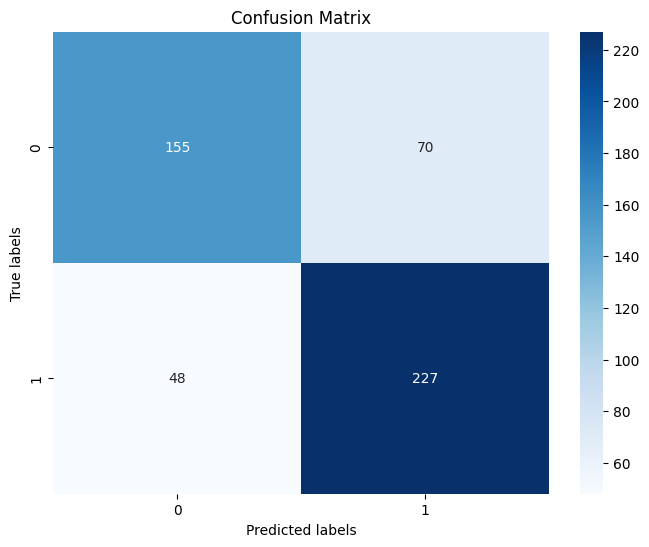

Accuracy: 0.764
Precision: 0.7643097643097643
Recall: 0.8254545454545454
F1 Score: 0.7937062937062938


In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

flattened_X_test = np.reshape(X_test_glove_embedded, (X_test_glove_embedded.shape[0], -1))
MLP_predications = mlp.predict(flattened_X_test)
cm = confusion_matrix(y_test, MLP_predications.round())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Calculate the accuracy, precision, recall and F1 score
accuracy = accuracy_score(y_test, MLP_predications.round())
precision = precision_score(y_test, MLP_predications.round())
recall = recall_score(y_test, MLP_predications.round())
f1 = f1_score(y_test, MLP_predications.round())

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

## MLP using keras embedding layer

<h3>Constructing the embedding matrix for the Embedding layer of the MLP<h3>

In this phase I will construct the embedding matrix for the embedding layer of the MLP this layer will convert a tokenized training set and testing set and convert it to it's glove embeddings then flatten it for input into the MLP

In [14]:
# Construct the model weight matrix for embedding layer
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if word in glove.key_to_index:
        embedding_vector = glove[word]
        embedding_matrix[i] = embedding_vector

<h2>Hyper-parameter settings for MLP using keras embedding layer<h2>

In [17]:
# Hyperparameters: MLP with Flattend glove word embeddings
batch_size = 32 # Baseline batch size
epochs = 10 # Baseline number of epochs
learning_rate = 0.05 # Baseline learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Baseline optimizer
validation_split = 0.1 # Baseline validation split: 10% of the training data
initializer = he_uniform(seed=42) # Baseline initializer
regularizer = l1(0.01) # Baseline regularizer
activation = 'relu' # Baseline activation function - leaky relu, used to prevent dying relu problem as minus numbers and zeros values are a possiblity for some inputs because of dimensional spaces of embedded dimensions
loss = 'binary_crossentropy' # Baseline loss function:binary crossentropy used for binary classification model
hl1_size = 3 # Baseline number of hidden layer neurons


<h3>Model Archetecture and compilation</h3>

Epoch 1/10
29/29 - 2s - loss: 91.7511 - acc: 0.5094 - val_loss: 92.7090 - val_acc: 0.5000 - 2s/epoch - 56ms/step
Epoch 2/10
29/29 - 1s - loss: 70.5749 - acc: 0.5411 - val_loss: 9.0197 - val_acc: 0.5000 - 1s/epoch - 43ms/step
Epoch 3/10
29/29 - 1s - loss: 44.9836 - acc: 0.5378 - val_loss: 50.5922 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 4/10
29/29 - 1s - loss: 40.2371 - acc: 0.5233 - val_loss: 6.4705 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 5/10
29/29 - 1s - loss: 47.5585 - acc: 0.5344 - val_loss: 41.6963 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 6/10
29/29 - 1s - loss: 15.2948 - acc: 0.5378 - val_loss: 20.3219 - val_acc: 0.5000 - 1s/epoch - 39ms/step
Epoch 7/10
29/29 - 1s - loss: 43.6035 - acc: 0.5000 - val_loss: 43.3005 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 8/10
29/29 - 1s - loss: 39.4559 - acc: 0.5367 - val_loss: 58.3676 - val_acc: 0.5000 - 1s/epoch - 40ms/step
Epoch 9/10
29/29 - 1s - loss: 41.1098 - acc: 0.5333 - val_loss: 38.3131 - val_acc: 0.5000 - 1s/epo

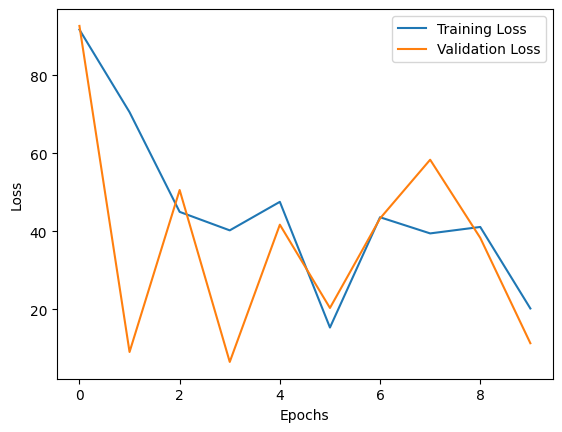

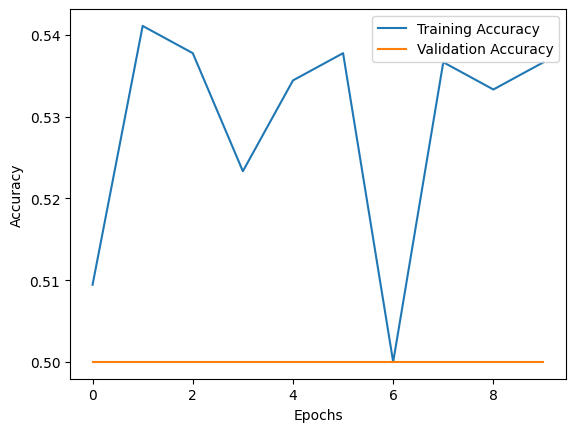

In [18]:
import time

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token

# Define the model
model_2 = Sequential()
model_2.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_len))  # Specify input length here
model_2.add(Flatten())  # Specify input shape here
model_2.add(Dense(hl1_size, activation=activation, kernel_initializer=initializer, kernel_regularizer=regularizer))
model_2.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizer))


# Model compilation
model_2.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

# fit the model and retrieve the training history
start_time = time.time()
history = model_2.fit(X_train, y_train, validation_split=validation_split, epochs=epochs, batch_size=batch_size, verbose=2)
end_time = time.time()

print(f"Time taken to train the model: {end_time - start_time} seconds")

def plot_metrics(train_metric, val_metric, metric_name):
    plt.plot(train_metric, label='Training ' + metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
train_accuracy = history.history['acc']

# Plot training and validation loss
plot_metrics(train_loss, val_loss, 'Loss')

# Plot training and validation accuracy
plot_metrics(train_accuracy, val_accuracy, 'Accuracy')

<h3>fit the model</h3>

16/16 [==============================] - 0s 7ms/step


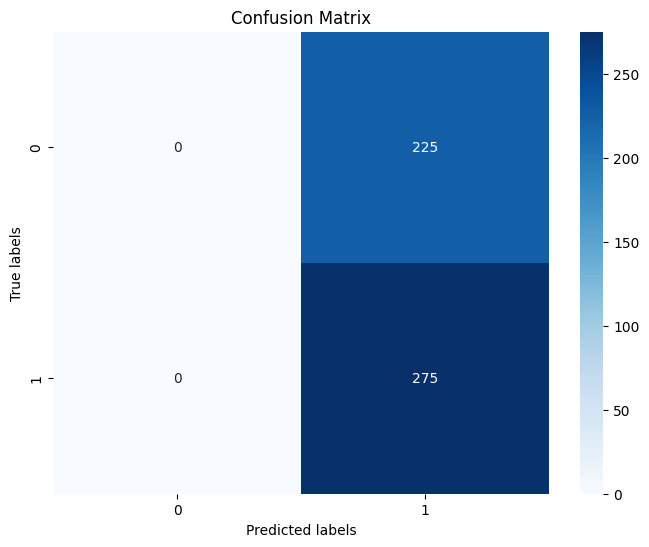

Accuracy: 0.55
Precision: 0.55
Recall: 1.0
F1 Score: 0.7096774193548387


In [19]:
embedded_mlp_history = model_2.predict(X_test)

def evaluate_model_performance(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Evaluate model performance
evaluate_model_performance(y_test, embedded_mlp_history.round())

<h5><u><center>Convolutional Neural Network</center></u></h5>
Below is the implementation of a convolutional neural network model using each record represented as a sequence of pre-trained word embedding vectors, leveraging the Keras Embedding layer.

In [40]:
from keras.layers import Conv1D, GlobalMaxPooling1D

cnn = Sequential()
cnn.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
cnn.add(Conv1D(128, 5, activation='relu', kernel_initializer=he_uniform(), kernel_regularizer=l1(0.001)))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(10, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = cnn.fit(X_train, y_train, validation_split=0.1, epochs=30, batch_size=32, verbose=2)


Epoch 1/30
57/57 - 6s - loss: 4.7894 - acc: 0.8000 - val_loss: 3.0617 - val_acc: 0.8700 - 6s/epoch - 107ms/step
Epoch 2/30
57/57 - 6s - loss: 1.9499 - acc: 0.9500 - val_loss: 1.3411 - val_acc: 0.9050 - 6s/epoch - 108ms/step
Epoch 3/30
57/57 - 6s - loss: 0.8924 - acc: 0.9783 - val_loss: 0.8259 - val_acc: 0.8750 - 6s/epoch - 109ms/step
Epoch 4/30
57/57 - 6s - loss: 0.5740 - acc: 0.9828 - val_loss: 0.6655 - val_acc: 0.8800 - 6s/epoch - 109ms/step
Epoch 5/30
57/57 - 7s - loss: 0.4181 - acc: 0.9933 - val_loss: 0.5694 - val_acc: 0.8850 - 7s/epoch - 121ms/step
Epoch 6/30
57/57 - 8s - loss: 0.3257 - acc: 0.9972 - val_loss: 0.5350 - val_acc: 0.8600 - 8s/epoch - 145ms/step
Epoch 7/30
57/57 - 8s - loss: 0.2663 - acc: 0.9983 - val_loss: 0.4744 - val_acc: 0.8900 - 8s/epoch - 135ms/step
Epoch 8/30
57/57 - 7s - loss: 0.2185 - acc: 0.9994 - val_loss: 0.4292 - val_acc: 0.9000 - 7s/epoch - 124ms/step
Epoch 9/30
57/57 - 7s - loss: 0.1856 - acc: 0.9994 - val_loss: 0.4112 - val_acc: 0.8850 - 7s/epoch - 123

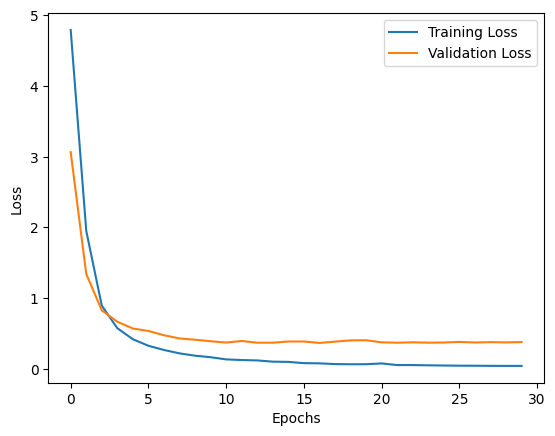

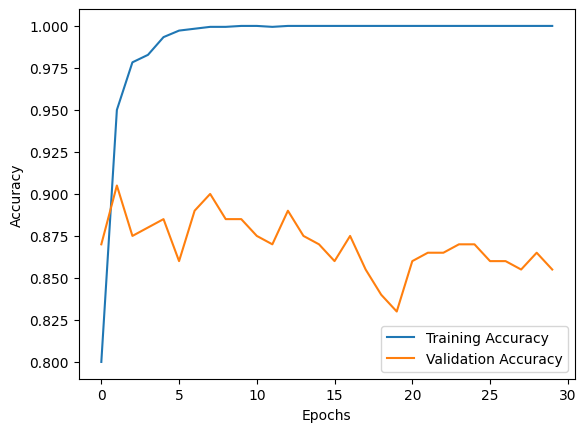

In [41]:
def plot_metrics(train_metric, val_metric, metric_name):
    plt.plot(train_metric, label='Training ' + metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
train_accuracy = history.history['acc']

# Plot training and validation loss
plot_metrics(train_loss, val_loss, 'Loss')

# Plot training and validation accuracy
plot_metrics(train_accuracy, val_accuracy, 'Accuracy')

<h5><center>Recurrent Neural Network (RNN)</center></h5>
<h5>
In this approach I utilizie a Recurrent Neural Netowr model where each record is represented as a sequence of pre-train word embedding vectors, using the Keras Embedding layer.
</h5>

In [42]:
from keras.layers import LSTM, Dense, Embedding

model = Sequential()
model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_len, trainable=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=32, verbose=2)


Epoch 1/10
57/57 - 74s - loss: 0.3949 - acc: 0.8217 - val_loss: 0.2824 - val_acc: 0.8850 - 74s/epoch - 1s/step
Epoch 2/10
57/57 - 69s - loss: 0.1885 - acc: 0.9283 - val_loss: 0.2259 - val_acc: 0.8900 - 69s/epoch - 1s/step
Epoch 3/10
57/57 - 70s - loss: 0.0757 - acc: 0.9733 - val_loss: 0.2659 - val_acc: 0.8900 - 70s/epoch - 1s/step
Epoch 4/10
57/57 - 67s - loss: 0.0252 - acc: 0.9939 - val_loss: 0.2080 - val_acc: 0.9100 - 67s/epoch - 1s/step
Epoch 5/10
57/57 - 71s - loss: 0.0119 - acc: 0.9983 - val_loss: 0.2850 - val_acc: 0.9050 - 71s/epoch - 1s/step
Epoch 6/10
57/57 - 72s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.3662 - val_acc: 0.9050 - 72s/epoch - 1s/step
Epoch 7/10
57/57 - 72s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.4338 - val_acc: 0.8950 - 72s/epoch - 1s/step
Epoch 8/10
57/57 - 72s - loss: 6.3816e-04 - acc: 1.0000 - val_loss: 0.4909 - val_acc: 0.8950 - 72s/epoch - 1s/step
Epoch 9/10
57/57 - 70s - loss: 4.3001e-04 - acc: 1.0000 - val_loss: 0.5387 - val_acc: 0.8950 - 70s/epoch - 1

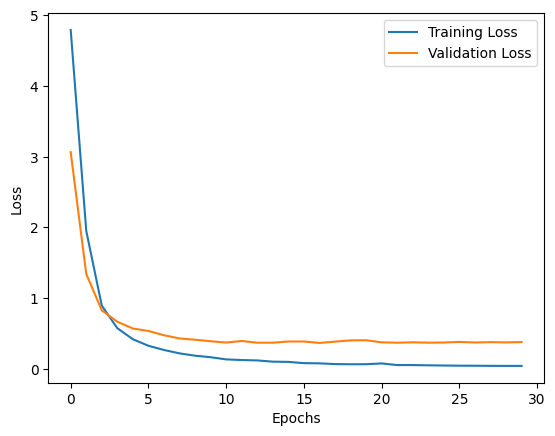

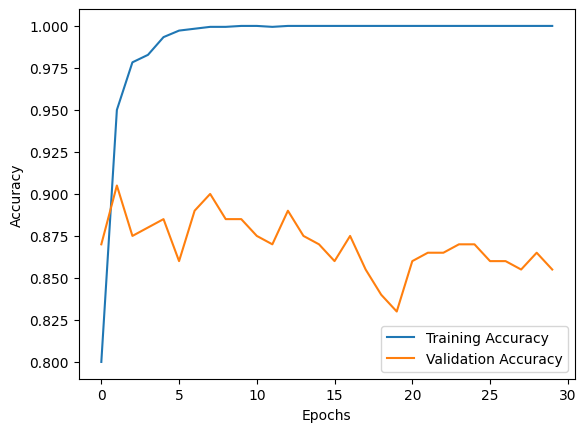

In [43]:
def plot_metrics(train_metric, val_metric, metric_name):
    plt.plot(train_metric, label='Training ' + metric_name)
    plt.plot(val_metric, label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Get validation history
val_loss = history.history['val_loss']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
train_accuracy = history.history['acc']

# Plot training and validation loss
plot_metrics(train_loss, val_loss, 'Loss')

# Plot training and validation accuracy
plot_metrics(train_accuracy, val_accuracy, 'Accuracy')

16/16 [==============================] - 0s 9ms/step


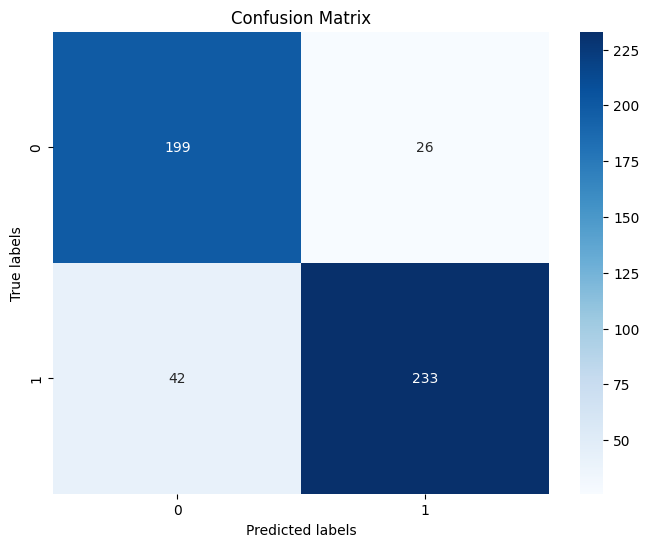

Accuracy: 0.864
Precision: 0.8996138996138996
Recall: 0.8472727272727273
F1 Score: 0.8726591760299626


In [44]:
embedded_mlp_history = model_2.predict(X_test)

def evaluate_model_performance(y_true, y_pred):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

# Evaluate model performance
evaluate_model_performance(y_test, embedded_mlp_history.round())